In [1]:
#this is the part of the code that we read the results given by 
#Faster R-CNN model and merge redundant bounding boxes and output the 
#final results in proper format for evaluation.
import cv2
import csv
import matplotlib.pyplot as plt
import lxml.etree as etree
import datetime
import xml.etree.ElementTree as ET

class Point:
    def __init__(self,setX,setY):
        self.x = setX
        self.y = setY
    def printPoint(self):
        print("x: "+str(self.x))
        print("y: "+str(self.y))
class BoundingBox:
    def __init__(self,setLogicalClass,setXLeft,setXRight,setYTop,setYBottom):
        self.logicalClass = setLogicalClass
        self.XLeft = setXLeft
        self.XRight = setXRight
        self.YTop = setYTop
        self.YBottom = setYBottom
    def printBox(self):
        print("logicalClass: "+str(self.logicalClass))
        print("x_left: "+str(self.XLeft))
        print("x_right: "+str(self.XRight))
        print("y_top: "+str(self.YTop))
        print("y_bottom: "+str(self.YBottom))

def read_image(image_path):
    image = cv2.imread(image_path)
    return image

def read_boxes(boxes_path):
    boxes_text_list = []
    boxes_picture_list = []
    with open(boxes_path,newline='') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            box = BoundingBox(int(row['label']),int(row['xmin']),int(row['xmax']),int(row['ymin']),int(row['ymax']))
#             print(row['label'])
            if(int(row['label'])==1): #text
#                 print("text")
                boxes_text_list.append(box)
            elif(int(row['label'])==2): #non-text
#                 print("not text")
                boxes_picture_list.append(box)
    return boxes_text_list,boxes_picture_list
def draw_boxes_in_image(image,boxes_text,boxes_picture,out_path):
    for box in boxes_text:
        xmin = int(box.XLeft)
        xmax = int(box.XRight)
        ymin = int(box.YTop)
        ymax = int(box.YBottom)
        start_point = (xmin,ymin)
        end_point = (xmax,ymax)
        color_text = (255, 0, 0)
        color_picture = (0, 255, 0)
        thickness = 3
        image_to_draw = cv2.rectangle(image, start_point, end_point, color_text, thickness) 
    for box in boxes_picture:
        xmin = int(box.XLeft)
        xmax = int(box.XRight)
        ymin = int(box.YTop)
        ymax = int(box.YBottom)
        start_point = (xmin,ymin)
        end_point = (xmax,ymax)
        color_picture = (0, 255, 0)
        thickness = 3
        image_to_draw = cv2.rectangle(image, start_point, end_point, color_picture, thickness) 
    cv2.imwrite(out_path,image_to_draw)
    return image_to_draw

#computing the overlaid area of two bounding boxes, 
#if the area is large enough to the smaller bounding box, 
#we merge them.
# ----------------------------------------------------------------#
def intersected_area(box_A, box_B):  # returns None if rectangles don't intersect
    dx = min(box_A.XRight, box_B.XRight) - max(box_A.XLeft, box_B.XLeft)
    dy = min(box_A.YBottom, box_B.YBottom) - max(box_A.YTop, box_B.YTop)
    if (dx>=0) and (dy>=0):
        return dx*dy
    else:
        return 0
def ratio_of_intersection_to_small_box(box_A,box_B):
    area_intersected = intersected_area(box_A,box_B)
    area_A = (box_A.XRight-box_A.XLeft)*(box_A.YBottom-box_A.YTop)
    area_B = (box_B.XRight-box_B.XLeft)*(box_B.YBottom-box_B.YTop)
    
    if(area_A>area_B):
        ratio = area_intersected/area_B
    else:
        ratio = area_intersected/area_A
        
    return ratio

def merging_rebounding_boxes(boxes):
    i=0
    j=0
    length_of_boxes_list = len(boxes)
    while(i<length_of_boxes_list):
            if(i!=j): #if the two bounding boxes are not the same box
                box_A = boxes[i]
                box_B = boxes[j]
                intersect_ratio = ratio_of_intersection_to_small_box(box_A,box_B)
                if(intersect_ratio>0.2): # we need to merge the boxes, and start over in case of any missing merge
                    x_left = min(int(box_A.XLeft),int(box_B.XLeft))
                    x_right = max(int(box_A.XRight),int(box_B.XRight))
                    y_top = min(int(box_A.YTop),int(box_B.YTop))
                    y_bottom = max(int(box_A.YBottom),int(box_B.YBottom))
                    logical_class = int(box_A.logicalClass)
                    boxes[i]= BoundingBox(logical_class,x_left,x_right,y_top,y_bottom)
                    del boxes[j]
                    length_of_boxes_list = len(boxes)
                    i=0 
                    j=0
                else: # we don't need to merge the boxes
                    j+=1
#                     print("hit")
                    if(j>=length_of_boxes_list):
                        j=0
                        i+=1
#                         print("hit2")
            else:
                j+=1
                if(j>=length_of_boxes_list):
                    j=0
                    i+=1
#             print("i: "+str(i))
#             print("j: "+str(j))

    return boxes
# ----------------------------------------------------------------#

# converting the merged result into proper format  (.xml) for evaluation
def recording_xml(image,boxes_text,boxes_picture,out_file_name):
    time = datetime.datetime.today()
    PcGts = ET.Element("PcGts")
    PcGts.set('xmlns','http://schema.primaresearch.org/PAGE/gts/pagecontent/2013-07-15')
    PcGts.set('xmlns:xsi','http://www.w3.org/2001/XMLSchema-instance')
    PcGts.set('xsi:schemaLocation','http://schema.primaresearch.org/PAGE/gts/pagecontent/2013-07-15 http://schema.primaresearch.org/PAGE/gts/pagecontent/2013-07-15/pagecontent.xsd')
    Metadata = ET.SubElement(PcGts,"Metadata")
    Creator = ET.SubElement(Metadata,"Creator")
    Created = ET.SubElement(Metadata,"Created").text = str(time.year)+"-"+str(time.month)+"-"+str(time.day)+"T"+str(time.hour)+":"+str(time.minute)+":"+str(time.second)
    LastChange = ET.SubElement(Metadata,"LastChange").text = str(time.year)+"-"+str(time.month)+"-"+str(time.day)+"T"+str(time.hour)+":"+str(time.minute)+":"+str(time.second)
    Page = ET.SubElement(PcGts,"Page")
    Page.set('imageFilename','image'+str(i)+'.jpg')
    height = image.shape[0]
    width = image.shape[1]
    Page.set('imageWidth',str(width))
    Page.set('imageHeight',str(height))
    index_count = 0
    for box in boxes_text:
        index_count+=1
        xl = box.XLeft
        if(xl<=0):
            xl+=1
        xr = box.XRight
        yt = box.YTop
        if(yt<=0):
            yt+=1
        yb = box.YBottom
        TextRegion = ET.SubElement(Page,'TextRegion')
        TextRegion.set('id',"r"+str(index_count))
        Coords = ET.SubElement(TextRegion,'Coords')
        Coords.set('points',str(xl)+","+str(yt)+" "+str(xl)+","+str(yb)+" "+str(xr)+","+str(yb)+" "+str(xr)+","+str(yt))

    for box in boxes_picture:
        index_count+=1
        xl = box.XLeft
        if(xl<=0):
            xl+=1
        xr = box.XRight
        yt = box.YTop
        if(yt<=0):
            yt+=1
        yb = box.YBottom
        ImageRegion = ET.SubElement(Page,'ImageRegion')
        ImageRegion.set('id',"r"+str(index_count))
        Coords = ET.SubElement(ImageRegion,'Coords')
        Coords.set('points',str(xl)+","+str(yt)+" "+str(xl)+","+str(yb)+" "+str(xr)+","+str(yb)+" "+str(xr)+","+str(yt))

    tree = ET.ElementTree(PcGts)
    tree.write(out_file_name,encoding='UTF-8', xml_declaration=True)

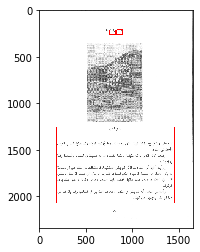

In [2]:
#reading the group of testing images
number_of_images = 30 
image_root = "bce_testing/PNGImages/"
boxes_root = "bce_csv_text_only/"
output_root = "BCE_test/results/"
output_xml_root = "BCE_test/result_xmls/"
boxes_text_list = []
boxes_picture_list = []

# removing redundant bounding boxes and convert the format
for i in range(number_of_images):
    image = read_image(image_root+str(i)+".png")
    boxes_text,boxes_picture = read_boxes(boxes_root+str(i)+"_boxes.csv")
    boxes_text = merging_rebounding_boxes(boxes_text)
    boxes_picture = merging_rebounding_boxes(boxes_picture)
    image_to_draw = draw_boxes_in_image(image,boxes_text,boxes_picture,output_root+str(i)+".png")
    out_file_name = output_xml_root+"result"+str(i)+".xml"
    recording_xml(image=image,boxes_text=boxes_text,boxes_picture=boxes_picture,out_file_name=out_file_name)
plt.imshow(image_to_draw)
plt.show()

